In [5]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 2D problem such as the Darcy Flow discussed in Section 5.2 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import os
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
from utilities3 import *

from Adam import Adam

from tqdm.auto import tqdm

torch.manual_seed(0)
np.random.seed(0)




def waveletShrinkage(x, thr, mode='soft'):
    """
    Perform soft or hard thresholding. The shrinkage is only applied to high frequency blocks.

    :param x: one block of wavelet coefficients, shape [num_nodes, num_hid_features] torch dense tensor
    :param thr: thresholds stored in a torch dense tensor with shape [num_hid_features]
    :param mode: 'soft' or 'hard'. Default: 'soft'
    :return: one block of wavelet coefficients after shrinkage. The shape will not be changed
    """
    assert mode in ('soft', 'hard', 'relu'), 'shrinkage type is invalid'

    if mode == 'soft':
        x = torch.mul(torch.sgn(x), (((torch.abs(x) - thr) + torch.abs(torch.abs(x) - thr)) / 2))
    elif mode == 'relu':
        x = torch.mul(x, (F.relu(torch.abs(x) - thr)))
    else:
        x = torch.mul(x, (torch.abs(x) > thr))

    return x


################################################################
# fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x
    
class FeedForward(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0., activation='gelu', layer=2, LN=False):
        super().__init__()
        if activation == 'relu':
            act = nn.ReLU
        elif activation == 'gelu':
            act = nn.GELU
        elif activation == 'tanh':
            act = nn.Tanh
        else: raise NameError('invalid activation')
         
        if LN:
            if layer == 2:
                self.net = nn.Sequential(
                    nn.Linear(in_dim, hidden_dim),
                    act(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_dim, out_dim)
                )
            elif layer == 3:
                self.net = nn.Sequential(
                    nn.Linear(in_dim, hidden_dim),
                    act(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_dim, hidden_dim),
                    act(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_dim, out_dim),
                    act(),
                    nn.LayerNorm(out_dim)
                )
            else: raise NameError('only accept 2 or 3 layers')
        else:
            if layer == 2:
                self.net = nn.Sequential(
                    nn.Linear(in_dim, hidden_dim),
                    act(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_dim, out_dim),
                )
            elif layer == 3:
                self.net = nn.Sequential(
                    nn.Linear(in_dim, hidden_dim),
                    act(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_dim, hidden_dim),
                    act(),
                    nn.Dropout(dropout),
                    nn.Linear(hidden_dim, out_dim),
                )
            else: raise NameError('only accept 2 or 3 layers')
            
    def forward(self, x):
        return self.net(x)
    def reset_parameters(self):
        for layer in self.children():
            for n, l in layer.named_modules():
                if hasattr(l, 'reset_parameters'):
                    print(f'Reset trainable parameters of layer = {l}')
                    l.reset_parameters()
                    
class FNO1d(nn.Module):
    def __init__(self, modes1, modes2,  width, num_spectral_layers=4, mlp_hidden_dim=128, mlp_LN=False, activation='gelu', mode_threshold=False, kernel_type='p', padding=9, lift_LN=False):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes = modes
        self.width = width
        self.num_spectral_layers = num_spectral_layers
        self.padding = padding # pad the domain if input is non-periodic
        if lift_LN:
            print('use liftLN')
            self.fc0 = nn.Sequential(
                    nn.Linear(2, self.width),
                    nn.LayerNorm(self.width))
        else:
            self.fc0 = nn.Linear(2, self.width) # input channel is 3: (a(x, y), x, y)
        self.Spectral_Conv_List = nn.ModuleList([])
        for _ in range(num_spectral_layers - 1):
            self.Spectral_Conv_List.append(SpectralConv1d(self.width, self.width, self.modes))
        self.Spectral_Conv_List.append(SpectralConv1d(self.width, self.width, self.modes))    
        
        self.Conv1d_list = nn.ModuleList([])
        if kernel_type == 'p':
            for _ in range(num_spectral_layers - 1):
                self.Conv1d_list.append(nn.Conv1d(self.width, 1))
        else:         
            for _ in range(num_spectral_layers - 1 ):
                self.Conv1d_list.append(nn.Conv1d(self.width, self.width, kernel_size=3, stride=1, padding=1, dilation=1))
        self.Conv1d_list.append(nn.Conv1d(self.width, self.width, kernel_size=3, stride=1, padding=1, dilation=1))
        
        if activation == 'relu':
            self.act = nn.ReLU()
        elif activation == 'gelu':
            self.act = nn.GELU()
        elif activation == 'tanh':
            self.act = nn.Tanh()
        elif activation == 'silu':
            self.act = nn.SiLU()
        else: raise NameError('invalid activation')       
          
        self.mlp = FeedForward(width, mlp_hidden_dim, 1, LN=mlp_LN)
        self.grid = None

    def forward(self, x):
        if self.grid is None:        
            grid = self.get_grid(x.shape, x.device)
            self.grid = grid
            x = torch.cat((x, grid), dim=-1)
        else: x = torch.cat((x, self.grid), dim=-1)
            
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0,self.padding])
        
        x1 = self.Spectral_Conv_List[0](x)
        x2 = self.Conv1d_list[0](x)
        x_shortcut = self.act(x1 + x2)

        
        for i in range(1, self.num_spectral_layers - 1):
            x1 = self.Spectral_Conv_List[i](x)
            x2 = self.Conv1d_list[i](x)
            x = x1 + x2
            x = self.act(x)
               
        x1 = self.Spectral_Conv_List[-1](x)
        x2 = self.Conv1d_list[-1](x)
        x = x1 + x2 + x_shortcut       

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 1)
        x = self.mlp(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)
    

    
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self, device):
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()
    
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True, truncation=True, res=256):
        super().__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average
        self.res = res
        if a == None:
            a = [1,] * k
        self.a = a
        k_x = torch.cat((torch.arange(start=0, end=res//2, step=1),torch.arange(start=-res//2, end=0, step=1)), 0).reshape(res,1)
        # k_y = torch.cat((torch.arange(start=0, end=res//2, step=1),torch.arange(start=-res//2, end=0, step=1)), 0).reshape(1,res).repeat(res,1)
        
        if truncation:
            self.k_x = (torch.abs(k_x)*(torch.abs(k_x)<20)).reshape(1,res, 1) 
            # self.k_y = (torch.abs(k_y)*(torch.abs(k_y)<20)).reshape(1,res,res,1) 
        else:
            self.k_x = torch.abs(k_x).reshape(1,res, 1) 
            # self.k_y = torch.abs(k_y).reshape(1,res,res,1) 
            
    def cuda(self, device):
        self.k_x = self.k_x.to(device)
        # self.k_y = self.k_y.to(device)

    def cpu(self):
        self.k_x = self.k_x.cpu()
        # self.k_y = self.k_y.cpu()

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        # ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], self.res, -1)
        y = y.view(y.shape[0], self.res, -1)

        

        x = torch.fft.fftn(x, dim=[1], norm='ortho')
        y = torch.fft.fftn(y, dim=[1], norm='ortho')

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (self.k_x**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
            l2loss = self.rel(x, y)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss, l2loss, x[:, :, 0], y[:, :, 0]
        
################################################################
# training and evaluation
################################################################

def objective(modes, width, data='darcy', learning_rate=0.001, weight_decay=1e-4, batch_size=20, num_spectral_layers=4, activation='gelu', mlp_hidden_dim=128, optimizer_type='Adam', show_conv=False, mode_threshold=False, kernel_type='p', loss_type='h1', epochs=100, step_size=100, sampling_rate=3, padding=9, scheduler_type='StepLR', mlp_LN=False, lift_LN=False, GN=True):
    
    ################################################################
    # configs
    ################################################################
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    TRAIN_PATH, TEST_PATH = getPath(data)

    ntrain = 1000
    ntest = 100

    epochs = epochs
    step_size = step_size
    gamma = 0.5



    r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
    ################################################################
    # load data and data normalization
    ################################################################
    dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
    x_data = dataloader.read_field('coeff')[:,::r]
    y_data = dataloader.read_field('sol')[:,::r]

    x_train = x_data[:ntrain,:]
    y_train = y_data[:ntrain,:]

    dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
    x_test = dataloader.read_field('coeff')[:ntest,::r]  
    y_test = dataloader.read_field('sol')[:ntest,::r] 
    
    if GN:
        x_normalizer = UnitGaussianNormalizer(x_train)
        x_train = x_normalizer.encode(x_train)
        x_test = x_normalizer.encode(x_test)

    s = x_train.size(1)

    x_train = x_train[...,np.newaxis]
    x_test = x_test[...,np.newaxis]

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)
    
    model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
    print(count_params(model))
    
    if optimizer_type.lower()=='adam':
        optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type.lower()=='adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_type.lower()=='torch.adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:  raise NameError('invalid optimizer_type')
    
    if scheduler_type.lower()=='steplr':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type.lower()=='onecyclelr':
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                               div_factor=1e1, 
                               final_div_factor=1e1,
                               pct_start=0.2,
                               steps_per_epoch=1, 
                               epochs=epochs)  
    else:  raise NameError('invalid scheduler_type')
  
    
    h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
    h1loss.cuda(device)
    l2loss = LpLoss(size_average=False)  
    
    y_normalizer = UnitGaussianNormalizer(y_train)
    y_normalizer.cuda(device)

    train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []
    
    with tqdm(total=epochs) as pbar_ep:
                            
        for epoch in range(epochs):
            model.train()
            train_l2, train_h1 = 0, 0
            train_f_dist = torch.zeros(s)
            
            for x, y in train_loader:
                optimizer.zero_grad()
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)
     
                if loss_type=='h1':
                    with torch.no_grad():
                        train_l2loss = l2loss(out, y)

                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                    train_h1loss.backward()
                else:
                    with torch.no_grad():
                        train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                    train_l2loss = l2loss(out, y)
                    train_l2loss.backward()
                    
                optimizer.step()
                train_h1 += train_h1loss.item()
                train_l2 += train_l2loss.item()
                train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

            ############################
            lr = optimizer.param_groups[0]['lr']

            scheduler.step()

            model.eval()
            test_l2, test_h1 = 0., 0.
            with torch.no_grad():
                for x, y in test_loader:
                    out = model(x).reshape(batch_size, s)
                    out = y_normalizer.decode(out)

                    test_l2 += l2loss(out, y).item()
                    test_h1 += h1loss(out, y)[0].item()

            train_l2/= ntrain
            train_h1/= ntrain
            test_l2 /= ntest
            test_h1/= ntest
            train_f_dist/= ntrain
            
            train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
            train_f_dist_rec.append(train_f_dist)
            
            desc = f"epoch: [{epoch+1}/{epochs}]"
            desc += f" | current lr: {lr:.3e}"
            desc += f"| train l2 loss: {train_l2:.3e} "
            desc += f"| train h1 loss: {train_h1:.3e} "
            desc += f"| val l2 loss: {test_l2:.3e} "
            desc += f"| val h1 loss: {test_h1:.3e} "
            pbar_ep.set_description(desc)
            pbar_ep.update()
         
        if show_conv:
            plt.figure(1)
            plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
            plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
            plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
            plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
            plt.grid(True, which="both", ls="--")
            plt.legend()
            plt.show()
            
            temp = torch.stack(train_f_dist_rec)
            plt.figure()
            plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
            plt.grid(True, which="both", ls="--")
            plt.legend(range(6))
            plt.show()
            
            plt.figure()
            plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
            plt.grid(True, which="both", ls="--")
            plt.legend(range(10,16))
            plt.show()
            
    return test_l2
        



In [52]:
config={
        "modes": 12,
        "width": 64,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 20,
        "sampling_rate": 4,
        "padding": None,
        "optimizer_type": 'adam',
        "loss_type": 'h1',
        "epochs": 500,
        "GN": True,
        "mlp_LN": False,
        "lift_LN": False,
        "scheduler_type": 'onecyclelr',
    }
for key, val in config.items():
    exec(key + '=val')
locals().update(config)

451265


  0%|          | 0/500 [00:00<?, ?it/s]

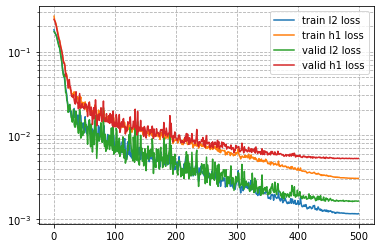

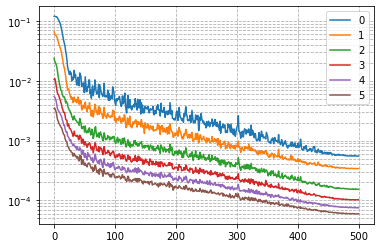

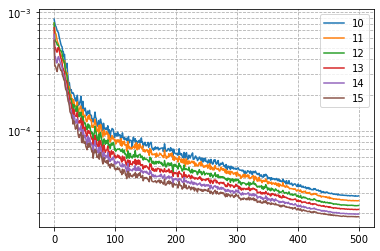

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAIN_PATH, TEST_PATH = getPath(data)

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5



r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
################################################################
# load data and data normalization
################################################################
dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
x_data = dataloader.read_field('coeff')[:,::r]
y_data = dataloader.read_field('sol')[:,::r]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r]  
y_test = dataloader.read_field('sol')[:ntest,::r] 

if GN:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

s = x_train.size(1)

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)

model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
print(count_params(model))

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.2,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')


h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()

451265


  0%|          | 0/500 [00:00<?, ?it/s]

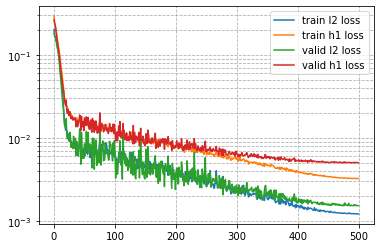

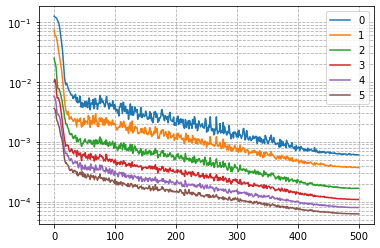

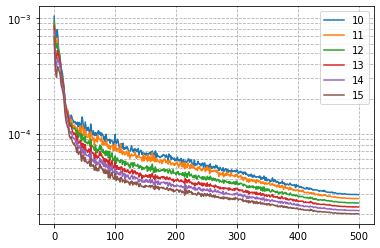

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAIN_PATH, TEST_PATH = getPath(data)

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5



r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
################################################################
# load data and data normalization
################################################################
dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
x_data = dataloader.read_field('coeff')[:,::r]
y_data = dataloader.read_field('sol')[:,::r]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r]  
y_test = dataloader.read_field('sol')[:ntest,::r] 

if GN:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

s = x_train.size(1)

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)

model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
print(count_params(model))

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.2,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')


h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()

In [55]:
config={
        "modes": 12,
        "width": 64,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 20,
        "sampling_rate": 4,
        "padding": None,
        "optimizer_type": 'adam',
        "loss_type": 'l2',
        "epochs": 500,
        "GN": True,
        "mlp_LN": False,
        "lift_LN": False,
        "scheduler_type": 'onecyclelr',
    }
for key, val in config.items():
    exec(key + '=val')
locals().update(config)

451265


  0%|          | 0/500 [00:00<?, ?it/s]

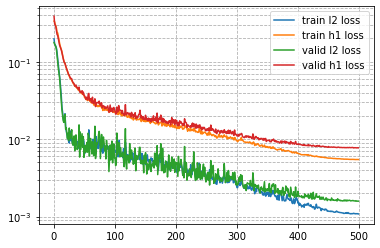

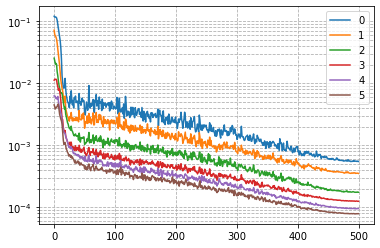

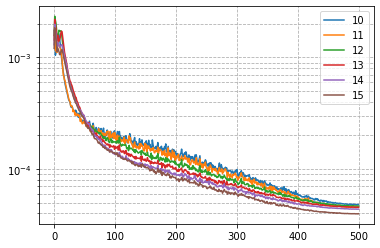

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAIN_PATH, TEST_PATH = getPath(data)

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5



r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
################################################################
# load data and data normalization
################################################################
dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
x_data = dataloader.read_field('coeff')[:,::r]
y_data = dataloader.read_field('sol')[:,::r]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r]  
y_test = dataloader.read_field('sol')[:ntest,::r] 

if GN:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

s = x_train.size(1)

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)

model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
print(count_params(model))

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.2,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')


h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()

582337


  0%|          | 0/500 [00:00<?, ?it/s]

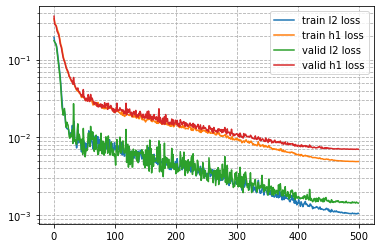

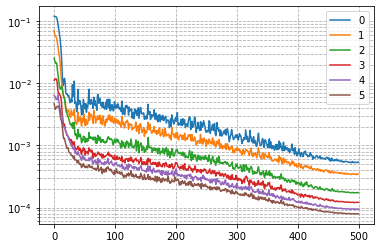

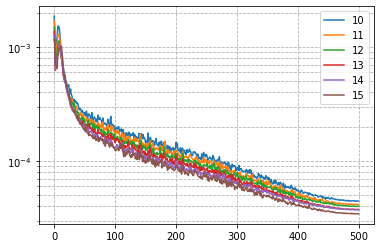

In [57]:
config={
        "modes": 16,
        "width": 64,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 20,
        "sampling_rate": 4,
        "padding": None,
        "optimizer_type": 'adam',
        "loss_type": 'l2',
        "epochs": 500,
        "GN": True,
        "mlp_LN": False,
        "lift_LN": False,
        "scheduler_type": 'onecyclelr',
    }
for key, val in config.items():
    exec(key + '=val')
locals().update(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAIN_PATH, TEST_PATH = getPath(data)

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5



r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
################################################################
# load data and data normalization
################################################################
dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
x_data = dataloader.read_field('coeff')[:,::r]
y_data = dataloader.read_field('sol')[:,::r]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r]  
y_test = dataloader.read_field('sol')[:ntest,::r] 

if GN:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

s = x_train.size(1)

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)

model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
print(count_params(model))

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.2,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')


h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()

use liftLN
582465


  0%|          | 0/500 [00:00<?, ?it/s]

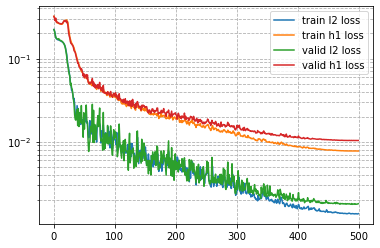

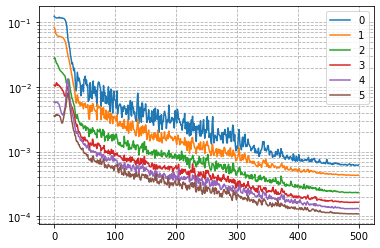

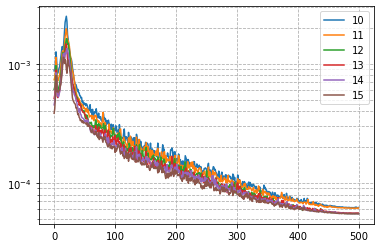

In [58]:
config={
        "modes": 16,
        "width": 64,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 50,
        "sampling_rate": 4,
        "padding": None,
        "optimizer_type": 'adam',
        "loss_type": 'l2',
        "epochs": 500,
        "GN": False,
        "mlp_LN": False,
        "lift_LN": True,
        "scheduler_type": 'onecyclelr',
    }
for key, val in config.items():
    exec(key + '=val')
locals().update(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAIN_PATH, TEST_PATH = getPath(data)

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5



r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
################################################################
# load data and data normalization
################################################################
dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
x_data = dataloader.read_field('coeff')[:,::r]
y_data = dataloader.read_field('sol')[:,::r]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r]  
y_test = dataloader.read_field('sol')[:ntest,::r] 

if GN:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

s = x_train.size(1)

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)

model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
print(count_params(model))

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.2,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')


h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()

582337


  0%|          | 0/500 [00:00<?, ?it/s]

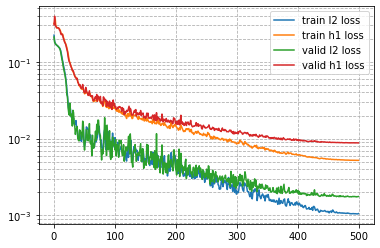

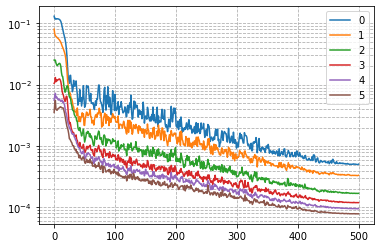

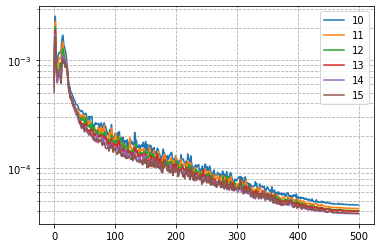

In [59]:
config={
        "modes": 16,
        "width": 64,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 50,
        "sampling_rate": 4,
        "padding": None,
        "optimizer_type": 'adam',
        "loss_type": 'l2',
        "epochs": 500,
        "GN": True,
        "mlp_LN": False,
        "lift_LN": False,
        "scheduler_type": 'onecyclelr',
    }
for key, val in config.items():
    exec(key + '=val')
locals().update(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAIN_PATH, TEST_PATH = getPath(data)

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5



r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
################################################################
# load data and data normalization
################################################################
dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
x_data = dataloader.read_field('coeff')[:,::r]
y_data = dataloader.read_field('sol')[:,::r]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r]  
y_test = dataloader.read_field('sol')[:ntest,::r] 

if GN:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

s = x_train.size(1)

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)

model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
print(count_params(model))

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.2,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')


h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()

582337


  0%|          | 0/500 [00:00<?, ?it/s]

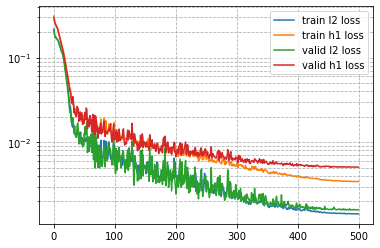

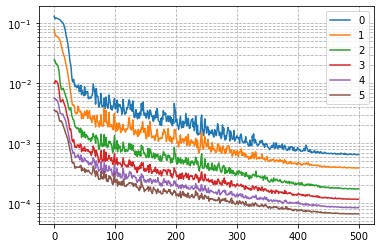

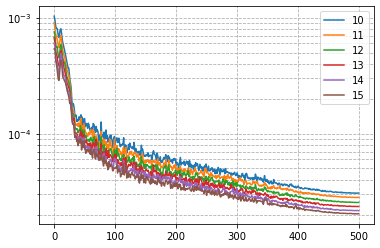

In [60]:
config={
        "modes": 16,
        "width": 64,
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "num_spectral_layers": 4,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 50,
        "sampling_rate": 4,
        "padding": None,
        "optimizer_type": 'adam',
        "loss_type": 'h1',
        "epochs": 500,
        "GN": True,
        "mlp_LN": False,
        "lift_LN": False,
        "scheduler_type": 'onecyclelr',
    }
for key, val in config.items():
    exec(key + '=val')
locals().update(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAIN_PATH, TEST_PATH = getPath(data)

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5



r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
################################################################
# load data and data normalization
################################################################
dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
x_data = dataloader.read_field('coeff')[:,::r]
y_data = dataloader.read_field('sol')[:,::r]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r]  
y_test = dataloader.read_field('sol')[:ntest,::r] 

if GN:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

s = x_train.size(1)

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)

model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
print(count_params(model))

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=1e1, 
                           final_div_factor=1e1,
                           pct_start=0.2,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')


h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()

2229505


  0%|          | 0/1000 [00:00<?, ?it/s]

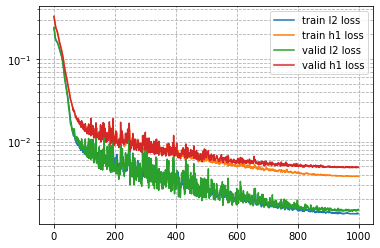

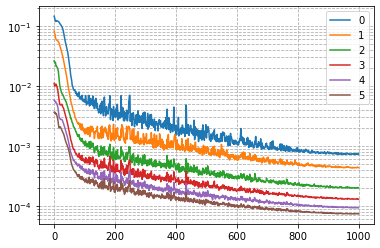

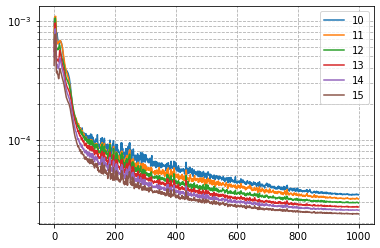

In [8]:
config={
        "modes": 12,
        "width": 128,
        "learning_rate": 1e-4,
        "weight_decay": 1e-4,
        "num_spectral_layers": 5,
        "activation": 'gelu',
        "mlp_hidden_dim": 128,
        "show_conv": True,
        "mode_threshold": False,
        "kernel_type": 'c',
        "batch_size": 50,
        "sampling_rate": 4,
        "padding": 9,
        "optimizer_type": 'adam',
        "loss_type": 'h1',
        "epochs": 1000,
        "GN": True,
        "mlp_LN": False,
        "lift_LN": False,
        "scheduler_type": 'onecyclelr',
    }
for key, val in config.items():
    exec(key + '=val')
locals().update(config)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TRAIN_PATH, TEST_PATH = getPath(data)

ntrain = 1000
ntest = 100

epochs = epochs
step_size = 100
gamma = 0.5



r = sampling_rate
#     h = int(((421 - 1)//r) + 1)
#     s = h
#     s = 128
################################################################
# load data and data normalization
################################################################
dataloader = MatReader('darcy1d_alpha2_tau10_1024_train.mat')
x_data = dataloader.read_field('coeff')[:,::r]
y_data = dataloader.read_field('sol')[:,::r]

x_train = x_data[:ntrain,:]
y_train = y_data[:ntrain,:]

dataloader.load_file('darcy1d_alpha2_tau10_1024_test.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r]  
y_test = dataloader.read_field('sol')[:ntest,::r] 

if GN:
    x_normalizer = UnitGaussianNormalizer(x_train)
    x_train = x_normalizer.encode(x_train)
    x_test = x_normalizer.encode(x_test)

s = x_train.size(1)

x_train = x_train[...,np.newaxis]
x_test = x_test[...,np.newaxis]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train.contiguous().to(device), y_train.contiguous().to(device)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test.contiguous().to(device), y_test.contiguous().to(device)), batch_size=batch_size, shuffle=False)

model = FNO1d(modes, modes, width, num_spectral_layers=num_spectral_layers, mlp_hidden_dim=mlp_hidden_dim, mode_threshold=mode_threshold, kernel_type=kernel_type, padding=padding, mlp_LN=mlp_LN, lift_LN=lift_LN).to(device)
print(count_params(model))

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=5, 
                           final_div_factor=5,
                           pct_start=0.3,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')


h1loss = HsLoss(d=2, p=2, k=1, size_average=False, res=s, a=[2.,])
h1loss.cuda(device)
l2loss = LpLoss(size_average=False)  

y_normalizer = UnitGaussianNormalizer(y_train)
y_normalizer.cuda(device)

train_h1_rec, train_l2_rec, train_f_dist_rec, test_l2_rec, test_h1_rec = [], [], [], [], []

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

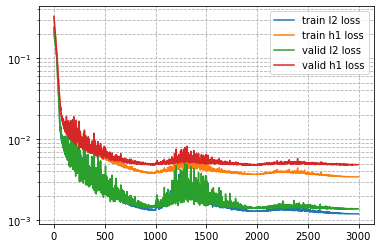

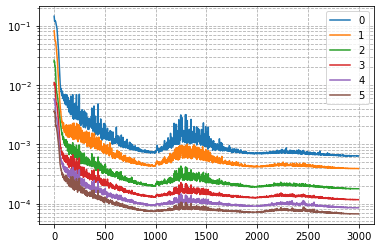

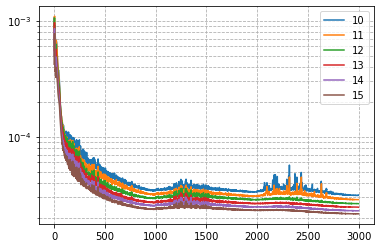

In [11]:
optimizer_type = 'adamw'
scheduler_type = 'onecyclelr'
learning_rate = 1e-5

if optimizer_type.lower()=='adam':
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='adamw':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='torch.adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
elif optimizer_type.lower()=='sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.)
else:  raise NameError('invalid optimizer_type')

if scheduler_type.lower()=='steplr':
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_type.lower()=='onecyclelr':
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                           div_factor=5, 
                           final_div_factor=5,
                           pct_start=0.3,
                           steps_per_epoch=1, 
                           epochs=epochs)  
else:  raise NameError('invalid scheduler_type')

with tqdm(total=epochs) as pbar_ep:

    for epoch in range(epochs):
        model.train()
        train_l2, train_h1 = 0, 0
        train_f_dist = torch.zeros(s)

        for x, y in train_loader:
            optimizer.zero_grad()
            out = model(x).reshape(batch_size, s)
            out = y_normalizer.decode(out)

            if loss_type=='h1':
                with torch.no_grad():
                    train_l2loss = l2loss(out, y)

                train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)
                train_h1loss.backward()
            else:
                with torch.no_grad():
                    train_h1loss, train_f_l2loss, f_l2x, f_l2y = h1loss(out, y)

                train_l2loss = l2loss(out, y)
                train_l2loss.backward()

            optimizer.step()
            train_h1 += train_h1loss.item()
            train_l2 += train_l2loss.item()
            train_f_dist += sum(torch.squeeze(torch.abs(f_l2x-f_l2y))).cpu()

        ############################
        lr = optimizer.param_groups[0]['lr']

        scheduler.step()

        model.eval()
        test_l2, test_h1 = 0., 0.
        with torch.no_grad():
            for x, y in test_loader:
                out = model(x).reshape(batch_size, s)
                out = y_normalizer.decode(out)

                test_l2 += l2loss(out, y).item()
                test_h1 += h1loss(out, y)[0].item()

        train_l2/= ntrain
        train_h1/= ntrain
        test_l2 /= ntest
        test_h1/= ntest
        train_f_dist/= ntrain

        train_l2_rec.append(train_l2); test_l2_rec.append(test_l2); train_h1_rec.append(train_h1); test_h1_rec.append(test_h1)
        train_f_dist_rec.append(train_f_dist)

        desc = f"epoch: [{epoch+1}/{epochs}]"
        desc += f" | current lr: {lr:.3e}"
        desc += f"| train l2 loss: {train_l2:.3e} "
        desc += f"| train h1 loss: {train_h1:.3e} "
        desc += f"| val l2 loss: {test_l2:.3e} "
        desc += f"| val h1 loss: {test_h1:.3e} "
        pbar_ep.set_description(desc)
        pbar_ep.update()

    if show_conv:
        plt.figure(1)
        plt.semilogy(np.array(train_l2_rec), label='train l2 loss')
        plt.semilogy(np.array(train_h1_rec), label='train h1 loss')
        plt.semilogy(np.array(test_l2_rec), label='valid l2 loss')
        plt.semilogy(np.array(test_h1_rec), label='valid h1 loss')
        plt.grid(True, which="both", ls="--")
        plt.legend()
        plt.show()

        temp = torch.stack(train_f_dist_rec)
        plt.figure()
        plt.semilogy(temp[:, 0:6].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(6))
        plt.show()

        plt.figure()
        plt.semilogy(temp[:, 10:16].detach().cpu().numpy())
        plt.grid(True, which="both", ls="--")
        plt.legend(range(10,16))
        plt.show()